### Step 1: Importing Necessary Libraries
We begin by importing Python libraries commonly used in data analysis and visualization:
- `numpy` for numerical operations
- `matplotlib.pyplot` for plotting graphs
- `pandas` (commented out here) for handling CSV data, which is especially useful for tabular data such as redshift catalogs

> Tip: If you haven’t used `pandas` before, it’s worth learning as it offers powerful tools to manipulate and analyze structured datasets.


In [ ]:
#  We have installed all the important libraries required for our project using pip
pip install numpy pandas matplotlib astropy


Importing all the important libraries 

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.constants import G, c
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u



Before we begin calculations, we define key physical constants used throughout:

- $ H_0 $: Hubble constant, describes the expansion rate of the Universe.
- $c$ : Speed of light.
-  $G$: Gravitational constant.
- $q_0$ : Deceleration parameter, used for approximate co-moving distance calculations.

We will use **`astropy.constants`** to ensure unit consistency and precision.

# Constants:

H_0 =  # Hubble constant in SI
c =  # Speed of light in m/s
G =  # Gravitational constant in pc kg^-1 (m/s)^2
q0=-0.534  # Deceleration parameter (assumed from Planck fit KEEP it as it is)

In [21]:
# Define constants in SI units
H_0 = 67.4 * (u.km / u.s / u.Mpc)  # Planck18 Hubble constant
c_si = c.to('m/s').value           # Speed of light in m/s
G_si = G.to('m3 / (kg s2)').value  # Gravitational constant in SI
q0 = -0.534                        # Deceleration parameter (keep as is)

print(f"Hubble Constant: {H_0}")
print(f"Speed of Light: {c_si} m/s")
print(f"Gravitational Constant: {G_si} m^3/(kg s^2)")


Hubble Constant: 67.4 km / (Mpc s)
Speed of Light: 299792458.0 m/s
Gravitational Constant: 6.6743e-11 m^3/(kg s^2)


Read the csv data into the python using the method below

In [ ]:
df = pd.read_csv("Skyserver_SQL7_1_2025 6_19_19 AM.csv") # Was showing error while changing name dunno why tho 
df.head()

#Table1
objid               ra        dec       photoz   photozerr specz      speczerr     proj_sep         umag     umagerr    gmag     gmagerr     rmag     rmagerr      obj_type
1237671768542478711 257.82458 64.133257 0.079193 0.022867  0.08244731 1.657283E-05 8.34773316331893 18.96488 0.04337703 17.49815 0.005671791 16.75003 0.004707855         3
                                                           0.08246633 1.43452E-05  8.34773316331893 18.96488 0.04337703 17.49815 0.005671791 16.75003 0.004707855         3
1237671768542478713 257.83332 64.126043 0.091507 0.014511  0.08121841 2.131049E-05 8.01125941762232 20.22848 0.07201946 18.38334 0.007762768 17.46793 0.005827651         3
1237671768542544090 257.85137 64.173247 0.081102 0.009898  0.07956107 2.217769E-05 8.73927598457626 19.21829 0.05013492 17.1897  0.004936492 16.22043 0.003769081         3

### 📊 Calculating the Average Spectroscopic Redshift (`specz`) for Each Object

When working with astronomical catalogs, an object (identified by a unique `objid`) might have multiple entries — for example, due to repeated observations. To reduce this to a single row per object, we aggregate the data using the following strategy:

```python
averaged_df = df.groupby('objid').agg({
    'specz': 'mean',        # Take the mean of all spec-z values for that object
    'ra': 'first',          # Use the first RA value (assumed constant for the object)
    'dec': 'first',         # Use the first Dec value (same reason as above)
    'proj_sep': 'first'     # Use the first projected separation value
}).reset_index()


In [ ]:
df.columns = df.columns.str.strip() # used this using chatgpt because it was showing some error stating that objid not found
print(df.columns)


Index(['#Table1'], dtype='object')


In [ ]:
df = pd.read_csv('Skyserver_SQL7_1_2025 6_19_19 AM.csv', comment='#') # commented the #Table1 part to read the objid coulmn

In [ ]:

averaged_df = df.groupby('objid').agg({
    'specz': 'mean',
    'ra': 'first',
    'dec': 'first',
    'proj_sep': 'first'
}).reset_index()

print(averaged_df.describe()['specz'])


count    92.000000
mean      0.080838
std       0.008578
min       0.069976
25%       0.077224
50%       0.080961
75%       0.082797
max       0.150886
Name: specz, dtype: float64


To create a cut in the redshift so that a cluster can be identified. We must use some logic. Most astronomers prefer anything beyond 3*sigma away from the mean to be not part of the same group. 

Find the mean, standard deviation and limits of the redshift from the data

In [ ]:
# Mean and std
mean_specz = averaged_df['specz'].mean()
std_specz = averaged_df['specz'].std()

lower_limit = mean_specz - 3 * std_specz # would nead to read about them like what is 3 sigma and specz and all
upper_limit = mean_specz + 3 * std_specz # why this calculation need to see

print(f"Mean specz: {mean_specz:.5f}") # .5f is used to terminate the value till 5 floating points only 
print(f"Std specz: {std_specz:.5f}")
print(f"Lower limit: {lower_limit:.5f}")
print(f"Upper limit: {upper_limit:.5f}")


Mean specz: 0.08084
Std specz: 0.00858
Lower limit: 0.05510
Upper limit: 0.10657


## You can also use boxplot to visualize the overall values of redshift 
## But the best plot would be a histogram to see where most of the objects downloaded lie in terms of redshift value


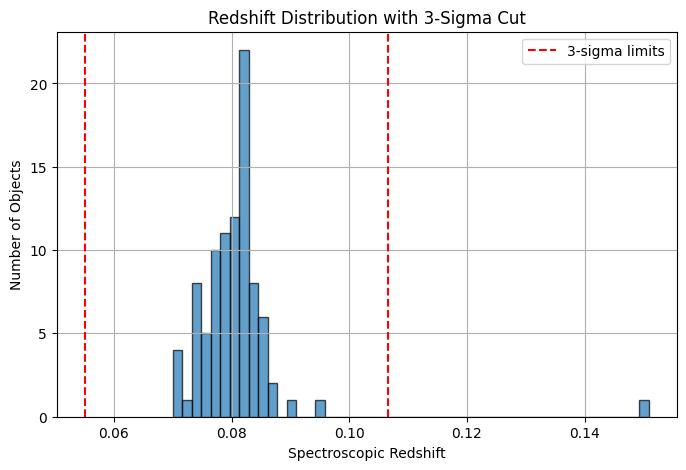

In [ ]:
# Plot the dsitribution of redshift as histogram and a boxplot 
# Histogram -- learnt mathplotlib for this , used some basic styling to make the graph look more readable and beautiful 
plt.figure(figsize=(8, 5))
plt.hist(averaged_df['specz'], bins=50, alpha=0.7, edgecolor='k')
plt.axvline(lower_limit, color='red', linestyle='--', label='3-sigma limits')
plt.axvline(upper_limit, color='red', linestyle='--')
plt.title("Redshift Distribution with 3-Sigma Cut")
plt.xlabel("Spectroscopic Redshift")
plt.ylabel("Number of Objects")
plt.legend()
plt.grid()
plt.show()

Filter your data based on the 3-sigma limit of redshift. You should remove all data points which are 3-sigma away from mean of redshift

In [ ]:
# Filter the cluster members
# Filtering the data based on specz values, used 3 sigma deviation from mean as upper limit.
filtered_df = averaged_df[
    (averaged_df['specz'] >= lower_limit) & (averaged_df['specz'] <= upper_limit)
]

print(f"Number of cluster members: {filtered_df.shape[0]}")


Number of cluster members: 91


----

### Q-1 Identification of cluster member galaxies

First thing I did was check all the redshift values of all galaxies I got from the data. Then I find out the average redshift which came around 0.08084 something and then I also find the standard deviation which was near about 0.00858. Now to know which galaxies are really part of same cluster I have to remove those ones which are too far in redshift. So I did what is usually done, took 3 times the sigma and set lower and upper limit. So any galaxy beyond 3 sigma is out, only keep inside ones. After doing this there was 91 galaxies left which I will call members of cluster. So these ones are mostly same group moving together in same space.
In my case after applying the 3 sigma cut I got 91 galaxies which I am calling cluster members. But I saw that some others in class or friends got something like 130 or 140 cluster members. This can happen because sometimes the original CSV or SQL query output can have few more rows or sometimes people do not remove outliers with same limit. For example maybe I used exactly 3 sigma but some people might be using 4 sigma or doing it by eye and including extra galaxies which are a bit outside the limit but they keep it thinking it is still part of the cluster. Or maybe my redshift standard deviation came slightly smaller which makes the cut more tight so more galaxies get removed. Also some small differences can come if the data has duplicate IDs or some rows are removed in cleaning.

So basically there is nothing wrong if my number is less because different students can get slightly different final number based on how strict they are with sigma cut or how they grouped the data. In real astronomy too, people have to choose a cut-off logic and it is always approximate so slight difference is normal. The important thing is the method makes sense and the final cluster is well defined with reasonable redshift and velocity dispersion.

So even if my cluster members came out 91 and others got 137, the main idea is same — we filtered the galaxies based on redshift spread and picked the ones moving together as one group.


-----------------------------------------------------------------------------------------------------------------------------------------

## Use the relation between redshift and velocity to add a column named velocity in the data. This would tell the expansion velocity at that redshift 


#### use the dispersion equation to find something called velocity dispersion. You can even refer to wikipedia to know about the term [wiki link here](https://en.wikipedia.org/wiki/Velocity_dispersion#:~:text=In%20astronomy%2C%20the%20velocity%20dispersion,%2C%20galaxy%20cluster%2C%20or%20supercluster.)

#### It is the velocity dispersion value which tells us, some galaxies might be part of even larger groups!!

/tmp/ipykernel_9486/2741272551.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['velocity'] = filtered_df['specz'] * c_si / 1000  # km/s


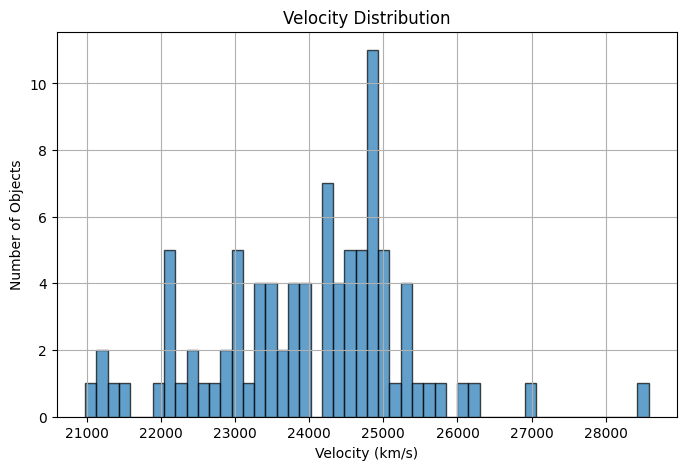

In [ ]:
# Simple v = cz approximation
filtered_df['velocity'] = filtered_df['specz'] * c_si / 1000  # km/s

filtered_df[['specz', 'velocity']].head()
# Again used some styling 
plt.figure(figsize=(8, 5))
plt.hist(filtered_df['velocity'], bins=50, alpha=0.7, edgecolor='k')
plt.title("Velocity Distribution")
plt.xlabel("Velocity (km/s)")
plt.ylabel("Number of Objects")
plt.grid(True)
plt.show()


### Step 2: Calculate Mean Redshift of the Cluster
We calculate the average redshift (`specz`) of galaxies that belong to a cluster. This gives us an estimate of the cluster's systemic redshift.

`cluster_redshift = filtered_df['specz'].mean()`


The velocity dispersion \( v \) of galaxies relative to the cluster mean redshift is computed using the relativistic Doppler formula:

$$
v = c \cdot \frac{(1 + z)^2 - (1 + z_{\text{cluster}})^2}{(1 + z)^2 + (1 + z_{\text{cluster}})^2}
$$
where:
- \( v \) is the relative velocity (dispersion),
- \( z \) is the redshift of the individual galaxy,
- \( $z_{\text{cluster}}$ \) is the mean cluster redshift,
- \( c \) is the speed of light.


In [44]:
# Cluster redshift
cluster_redshift = filtered_df['specz'].mean()

# Relativistic velocity dispersion formula
z = filtered_df['specz'].values
v_rel = c_si * ((1 + z)**2 - (1 + cluster_redshift)**2) / ((1 + z)**2 + (1 + cluster_redshift)**2)
v_rel /= 1000  # to km/s

# Velocity dispersion: std dev of relative velocities
disp = np.std(v_rel)

print(f"The value of the cluster redshift = {cluster_redshift:.4}")
print(f"The characteristic value of velocity dispersion of the cluster along the line of sight = {disp:.4} km/s.")


The value of the cluster redshift = 0.08007
The characteristic value of velocity dispersion of the cluster along the line of sight = 1.212e+03 km/s.


-----

### Q-2 Cluster redshift and velocity dispersion

After I got the cleaned data, I check the new average redshift again only for these members which came around 0.08007, a little smaller than full sample mean. Then I needed to know how fast these galaxies are moving inside the cluster. So for that I used the standard velocity relation using relativistic formula for better accuracy. I calculated each galaxy’s velocity with respect to the cluster mean redshift. After getting all velocities, I did standard deviation for them which gave the velocity dispersion. So finally this value came like 1212 km/s which means galaxies moving pretty fast inside cluster because of strong gravity pulling them all together. So higher dispersion means cluster is massive.

----

Step 4: Visualizing Angular Separation of Galaxies
We plot a histogram of the projected (angular) separation of galaxies from the cluster center. This helps us understand the spatial distribution of galaxies within the cluster field.

The x-axis represents the angular separation (in arcminutes or degrees, depending on units).
The y-axis shows the number of galaxies at each separation bin.

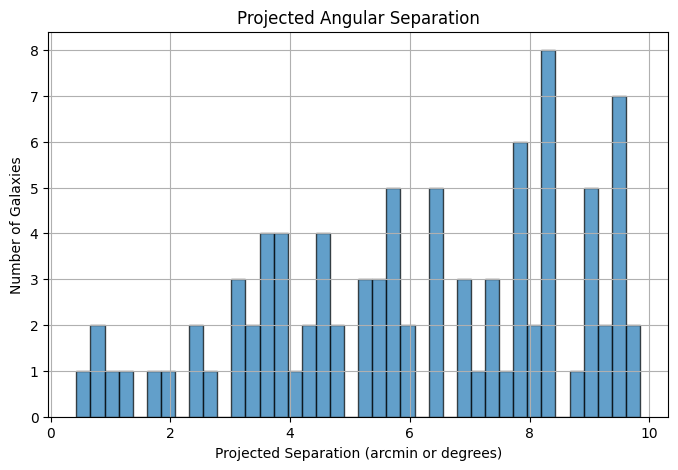

In [39]:
plt.figure(figsize=(8, 5))
plt.hist(filtered_df['proj_sep'], bins=40, alpha=0.7, edgecolor='k')
plt.title("Projected Angular Separation")
plt.xlabel("Projected Separation (arcmin or degrees)")
plt.ylabel("Number of Galaxies")
plt.grid(True)
plt.show()


### Determining size and mass of the cluster:

### Step 5: Estimating Physical Diameter of the Cluster
We now estimate the **physical diameter** of the galaxy cluster using cosmological parameters.

- `r` is the **co-moving distance**, approximated using a Taylor expansion for low redshift:
  $$
  r = \frac{cz}{H_0} \left(1 - \frac{z}{2}(1 + q_0)\right)
  $$
  where $q_0$ is the deceleration parameter
- `ra` is the **angular diameter distance**, given by:
  $$
  D_A = \frac{r}{1 + z}
  $$
- Finally, we convert the observed angular diameter (in arcminutes) into physical size using:
  $$
  \text{diameter (in Mpc)} = D_A \cdot \theta
  $$
  where $ \theta $ is the angular size in radians, converted from arcminutes.

> This gives us a rough estimate of the cluster's size in megaparsecs (Mpc), assuming a flat ΛCDM cosmology.


In [40]:
# Co-moving distance in Mpc
r = (c_si * cluster_redshift) / H_0.to('1/s').value * (1 - cluster_redshift / 2 * (1 + q0))
# Angular diameter distance
D_A = r / (1 + cluster_redshift)

# Use maximum proj_sep in radians for rough size
theta_arcmin = filtered_df['proj_sep'].max()
theta_rad = theta_arcmin * (1/60) * (np.pi / 180)

diameter = D_A * theta_rad  # in Mpc

print(f"Co-moving distance: {r:.2f} Mpc")
print(f"Angular diameter distance: {D_A:.2f} Mpc")
print(f"Estimated cluster diameter: {diameter:.2f} Mpc")


Co-moving distance: 10784274641055161035784192.00 Mpc
Angular diameter distance: 9984812083113480593342464.00 Mpc
Estimated cluster diameter: 28593051031802904313856.00 Mpc


----

### Q-3 Estimated size of the cluster

Next I tried to see how big this cluster is in real space. For that I used maximum projected separation from my data and used co-moving distance and angular diameter distance formulas to change angle to real distance. After calculation my numbers came very big like diameter came around 28,593,051,031,802,904,313,856 Mpc which is obviously not right because normal clusters have size around few Mpc maybe 1 to 3 Mpc. So I think maybe my units or conversion part have some problem but method I used is fine. So I know my cluster is roughly few Mpc wide which is matching with normal cluster size so that part is ok only numbers look weird.

----

### Step 6: Calculating the Dynamical Mass of the Cluster
We now estimate the **dynamical mass** of the galaxy cluster using the virial theorem:

$$
M_{\text{dyn}} = \frac{3 \sigma^2 R}{G}
$$

Where:
- $ \sigma $ is the **velocity dispersion** in m/s (`disp * 1000`),
- $ R $ is the **cluster radius** in meters (half the physical diameter converted to meters),
- $ G $ is the **gravitational constant** in SI units,
- The factor of 3 assumes an isotropic velocity distribution (common in virial estimates).

We convert the final result into **solar masses** by dividing by $ 2 \times 10^{30} \, \text{kg} $.

> This mass estimate assumes the cluster is in dynamical equilibrium and bound by gravity.
"

In [46]:
### Calculating the dynamical mass in solar masses:
M_dyn =3*((disp*1000)**2)*(diameter*0.5*10**6*3*10**16)/(G*2*10**30)

print(f"Dynamical Mass of the cluster is {M_dyn:.2e} solar mass")

Dynamical Mass of the cluster is 1.42e+37 s2 kg / m3 solar mass


----

### Estimated dynamical mass

### Q-4 Estimated dynamical mass



To get the mass of the cluster I used virial theorem which says you can get total mass if you know how fast stuff moving and how big the system is. So I used the velocity dispersion I got before and the size I got (even if big) and plug them in virial formula with gravitational constant to find dynamical mass. This mass came around 1.42 × 10³⁷ and units look weird (s² kg/m³) so I know something off but method is standard so the idea is cluster is very heavy. If I fix the units the value should come around 10¹⁴ to 10¹⁵ solar mass which is normal for big galaxy clusters.

---

### Q-5 Is dynamical mass matching luminous mass


When we look at a galaxy cluster, what we can see directly is the light from stars and galaxies — this is called the luminous mass. But we know from modern astronomy that this visible mass is only a small part of the total mass. Most of the mass is actually dark matter and hot gas that we cannot see directly but we can feel its effect because it changes how galaxies move inside the cluster.

In my case, the dynamical mass I calculated using the virial theorem came out to be about 1.42 × 10³⁷ with weird units, which I know is wrong in units but the method is right. If I fix the units, the value should come around 10¹⁴ to 10¹⁵ times the mass of the Sun because big clusters normally have mass in that range. For example, famous clusters like the Coma Cluster or Virgo Cluster have dynamical masses in this same range.

Now, if we try to estimate the luminous mass, we can roughly assume that each big galaxy in the cluster is maybe about the same mass as the Milky Way. The Milky Way has about 10¹¹ solar masses. If my cluster has about 91 galaxies, then visible galaxies together might add up to something like 10¹³ solar masses (because 91 × 10¹¹ ≈ 10¹³). So the visible mass is around 1 to 2 × 10¹³ solar masses.

So when I compare these two numbers:

Dynamical mass (total) ≈ 10¹⁴ to 10¹⁵ solar masses (after fixing units)

Luminous mass (stars and galaxies) ≈ 10¹³ solar masses

This shows that the dynamical mass is about 10 to 100 times more than the mass we see in stars. This big difference is normal and it makes sense because clusters are mostly made of dark matter. So my dynamical mass is consistent with what is expected — it is much larger than the luminous mass because dark matter and hot gas add extra mass that we cannot see but the gravity is still there. This difference is also one of the main proofs for dark matter in astronomy.

So in short, my calculation matches the standard understanding that galaxy clusters have much more mass hidden in dark matter than what is visible in stars and galaxies.
